# Creating an example of a circuit cost function

In [1]:
from qiskit.circuit import QuantumCircuit
from qiskit import execute, BasicAer, Aer
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_distribution
from random import randrange
from numpy import pi
from project.unified_noise_model.Unified_Noise_Model import Unified_Noise_Model
import numpy as np
from scipy.optimize import minimize

In [2]:
def get_cost(key):
    z = np.array(list(key), dtype=int)
    if key == '000000':
        cost = np.sum(z)  
    else:
        cost = np.sum(z) + 10
    return cost

In [3]:
def quantum_circuit(param, num_qubits,num_iterations):
    qc = QuantumCircuit(num_qubits,num_qubits)
    
    for itr in range(num_iterations):
        for q in range(num_qubits):
            qc.rz(param[itr],q)
            qc.rz(param[itr+ num_iterations],q)
            qc.ry(param[itr+ 2*num_iterations],q)
            qc.ry(param[itr+ 3*num_iterations],q)
            #qc.rx(param[itr+ 4*num_iterations],q)
            #qc.rx(param[itr+ 5*num_iterations],q)
            
    qc.measure(range(num_qubits),range(num_qubits))
    return qc

In [4]:
def get_avg_cost(circuit, num_qubits, noise_model):
    
    shots=4000
    
    simulator = AerSimulator(noise_model=noise_model)
    result = simulator.run(circuit,shots=shots).result()
    counts = result.get_counts(0)

    avg_cost = sum(counts[key] * get_cost(key) for key in counts)
    
    avg_cost = avg_cost / sum(counts.values()) 

    #costs.append(avg_cost )
    
    return avg_cost

In [5]:
def func(param, *args):
    num_qubits = args[0][0]
    num_iterations = args[0][1]
    noise_model = args[0][2]
    circuit = quantum_circuit(param,num_qubits,num_iterations)
    cost = get_avg_cost(circuit, num_qubits, noise_model)

    return cost

In [6]:
def cost_func_test_param(param, num_qubits,num_iterations,noise_model):
    qc = QuantumCircuit(num_qubits,num_qubits)
    shots=4000

    for itr in range(num_iterations):
        for q in range(num_qubits):
            qc.rz(param[itr],q)
            qc.rz(param[itr+ num_iterations],q)
            qc.ry(param[itr+ 2*num_iterations],q)
            qc.ry(param[itr+ 3*num_iterations],q)
            #qc.rx(param[itr+ 4*num_iterations],q)
            #qc.rx(param[itr+ 5*num_iterations],q)
    qc.measure(range(num_qubits),range(num_qubits))
    display(qc.draw('mpl'))
    
    #Run the circuit 10000 times and store the results
    simulator = AerSimulator(noise_model=noise_model)
    result = simulator.run(qc,shots=shots).result()
    counts = result.get_counts(0)
    display(plot_distribution(counts,title = 'Optimize Results',figsize=[18,7]))
    
    avg_cost = sum(counts[key] * get_cost(key) for key in counts)
    avg_cost = avg_cost / sum(counts.values()) 
    print(avg_cost)
    return avg_cost

In [7]:
def cost_func_random(num_qubits,num_iterations,noise_model):
    qc = QuantumCircuit(num_qubits,num_qubits)
    shots=4000
    
    for itr in range(num_iterations):
        random_phi1 = np.random.uniform(0, 1)
        random_phi2 = np.random.uniform(0, 1)
        random_phi3 = np.random.uniform(0, 1)
        for q in range(num_qubits):
            qc.rz(random_phi1*pi,q)
            qc.rz(-random_phi1*pi,q)
            qc.ry(random_phi2*pi,q)
            qc.ry(-random_phi2*pi,q)
            #qc.rx(random_phi3*pi,q)
            #qc.rx(-random_phi3*pi,q)
            
    qc.measure(range(num_qubits),range(num_qubits))
    display(qc.draw('mpl'))
    
    #Noiseless 
    job = execute (qc,Aer.get_backend('qasm_simulator'),shots=shots)
    job_result = job.result()
    counts_noiseless = job_result.get_counts(qc)
    display(plot_distribution(counts_noiseless,title='Noiseless Results' ,figsize=[18,7]))
    
    simulator_noise = AerSimulator(noise_model=noise_model)
    result_noise = simulator_noise.run(qc,shots=shots).result()
    counts_noise = result_noise.get_counts(0)
    display(plot_distribution(counts_noise,title='Noisy Results' ,figsize=[18,7]))
    
    avg_cost = sum(counts_noise[key] * get_cost(key) for key in counts_noise)
    avg_cost = avg_cost / sum(counts_noise.values()) 
    #print(avg_cost)
    
    return avg_cost

/home/onofre/anaconda3/envs/noise_native_gates/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


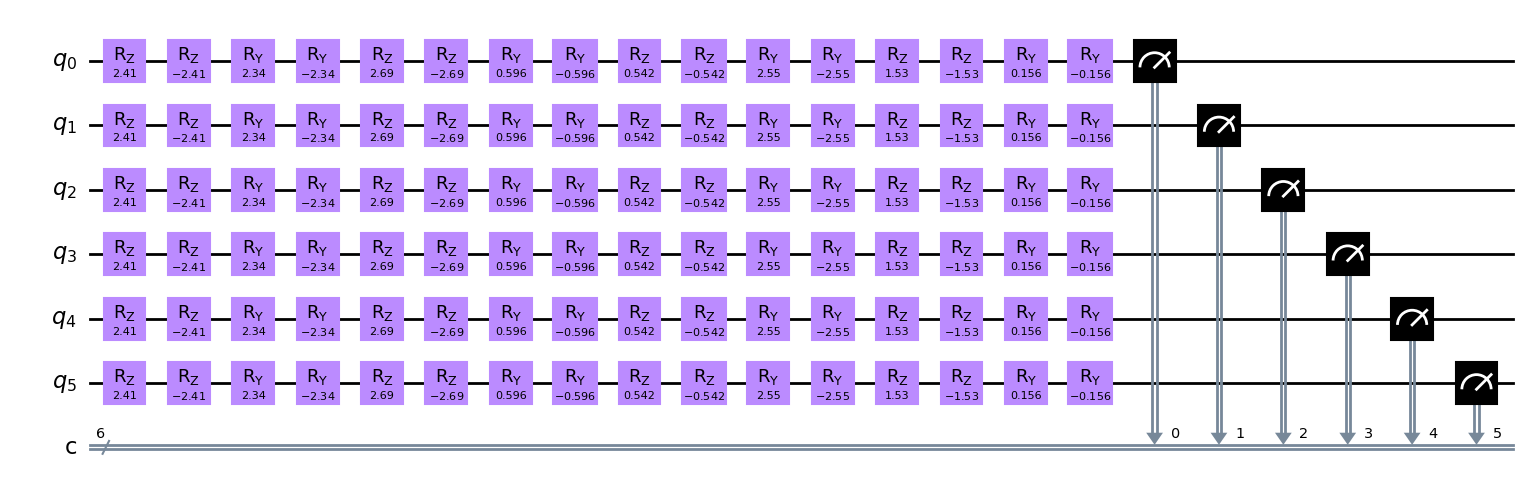

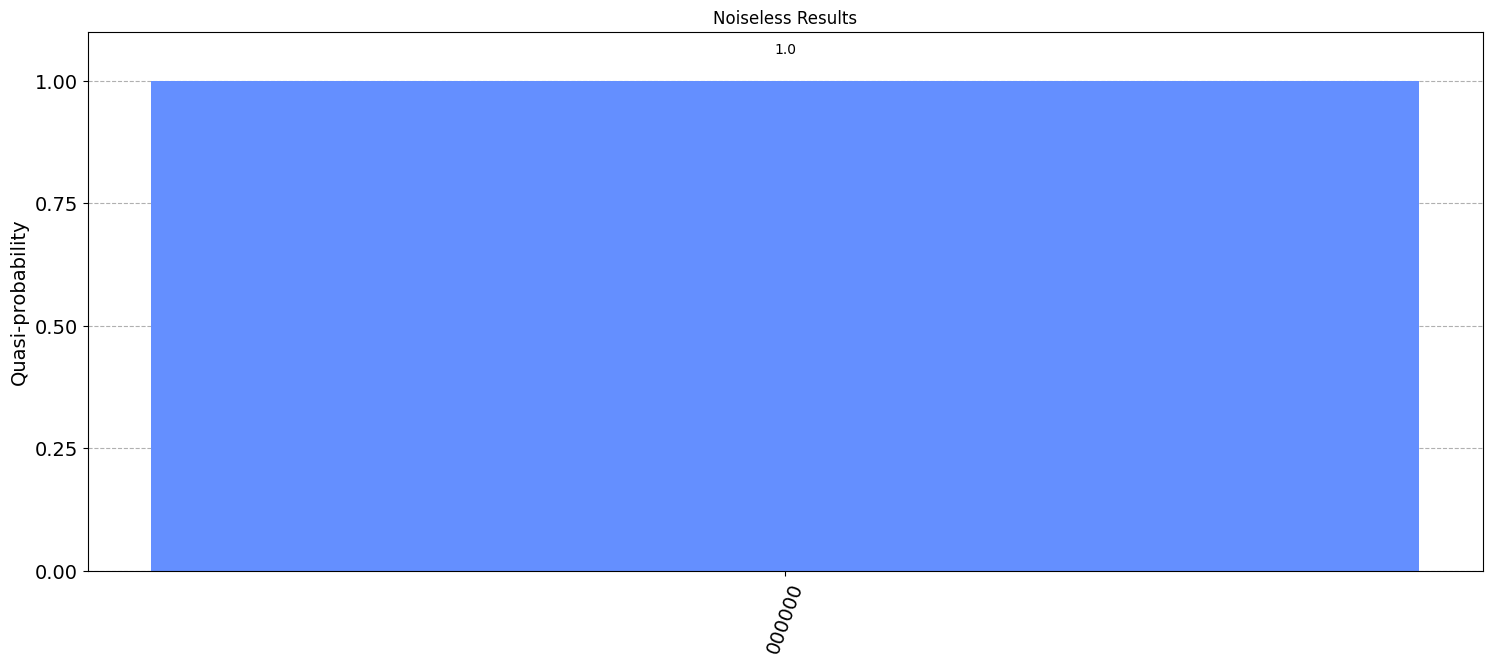

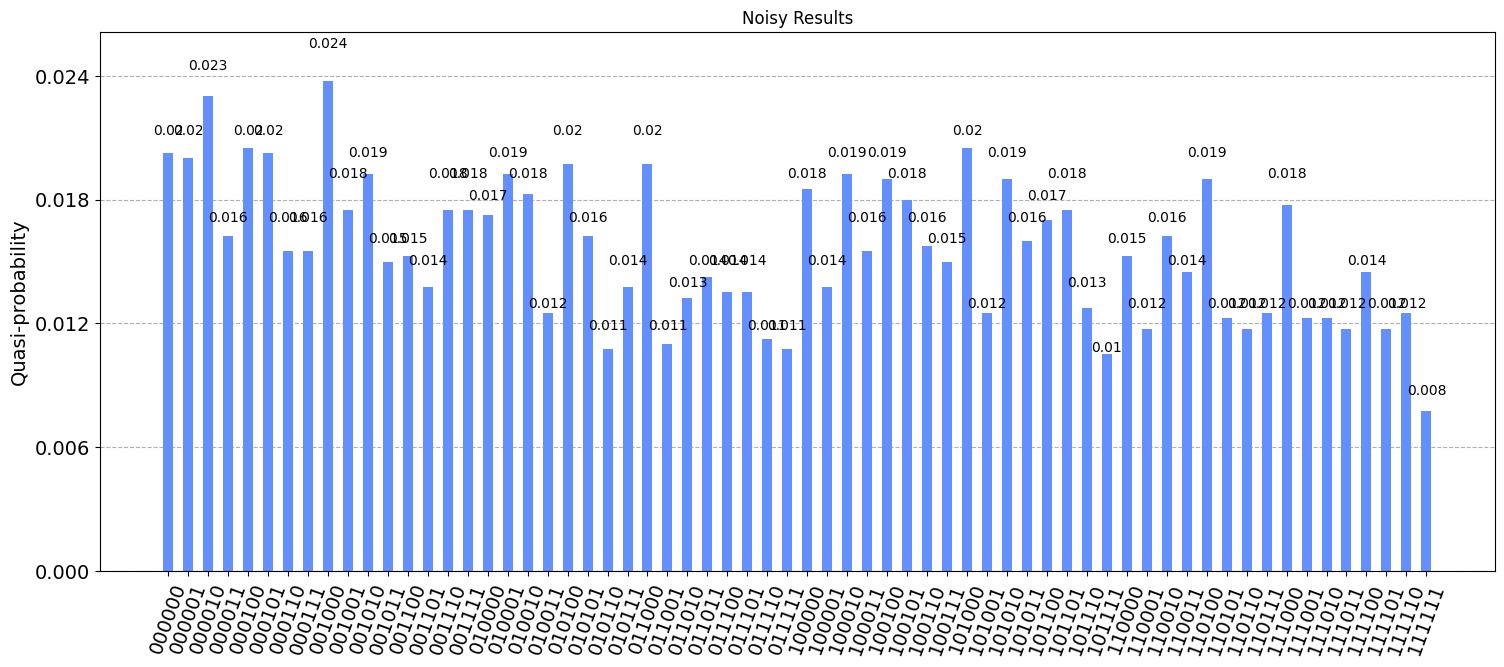

cost: 12.59375 



In [8]:
num_iterations = 4
num_qubits = 6
depol_noise_prob = 0.15
                
unm = Unified_Noise_Model()
unm.add_depolarizing_channel(depol_noise_prob,['rz', 'ry'],[])

cost = cost_func_random(num_qubits,num_iterations,unm.noise_model) 
print('cost:',cost,'\n')

In [14]:
def multiple_minimizations(repetitions, num_qubits,num_iterations, depol_noise_prob):

    #noise model
    unm = Unified_Noise_Model()
    unm.add_depolarizing_channel(depol_noise_prob,['rz', 'ry'],[])
    #print(unm.noise_model)
    scores = []
    params = []

    for repetition in range(repetitions):
        param = []
        #costs = []
        for i in range(num_iterations):            
            param.append( np.random.uniform(0, 1) * pi)
            param.append( np.random.uniform(0, 1)* pi)
            param.append( np.random.uniform(0, 1)* pi)
            param.append( np.random.uniform(0, 1) * pi)
        
        result = minimize(
            fun=func,
            x0=param,
            args=[num_qubits,num_iterations,unm.noise_model],
            method='COBYLA',
            tol=1e-7,
            options={"maxiter": 85000}
        )
        #plt.plot(range(len(costs)),costs, label='Cost Function')
        #plt.xlabel('optimization step')
        #plt.ylabel('cost')
        
        scores.append(result.fun)
        params.append(result.x)
        
    optimal_parameters = params[np.argmin(scores)]
    
    #cost = func(result.x,[num_qubits,num_iterations,unm.noise_model])
    
    return optimal_parameters, scores, params

In [15]:
optimal_parameters, scores, params =  multiple_minimizations(15, num_qubits,num_iterations, depol_noise_prob)

In [16]:
scores

[12.56025,
 12.58375,
 12.541,
 12.5955,
 12.576,
 12.594,
 12.6035,
 12.5675,
 12.5495,
 12.6175,
 12.528,
 12.61525,
 12.585,
 12.5355,
 12.50125]

In [17]:
optimal_parameters

array([ 1.02431928,  3.99147385,  2.5476343 , -0.1649887 ,  2.15942328,
        4.08287111,  2.78666114,  2.54602723,  0.53961771,  1.58871133,
        1.42469636,  2.58365338,  0.56413019,  0.01300676,  0.27041595,
        0.45148658])

/home/onofre/anaconda3/envs/noise_native_gates/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


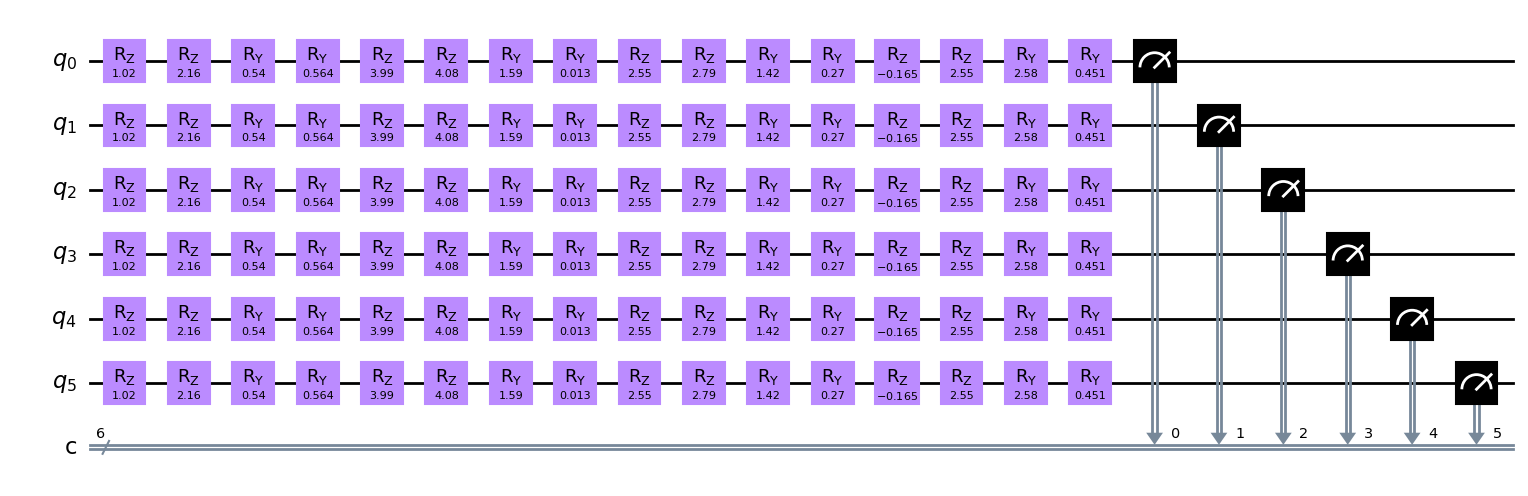

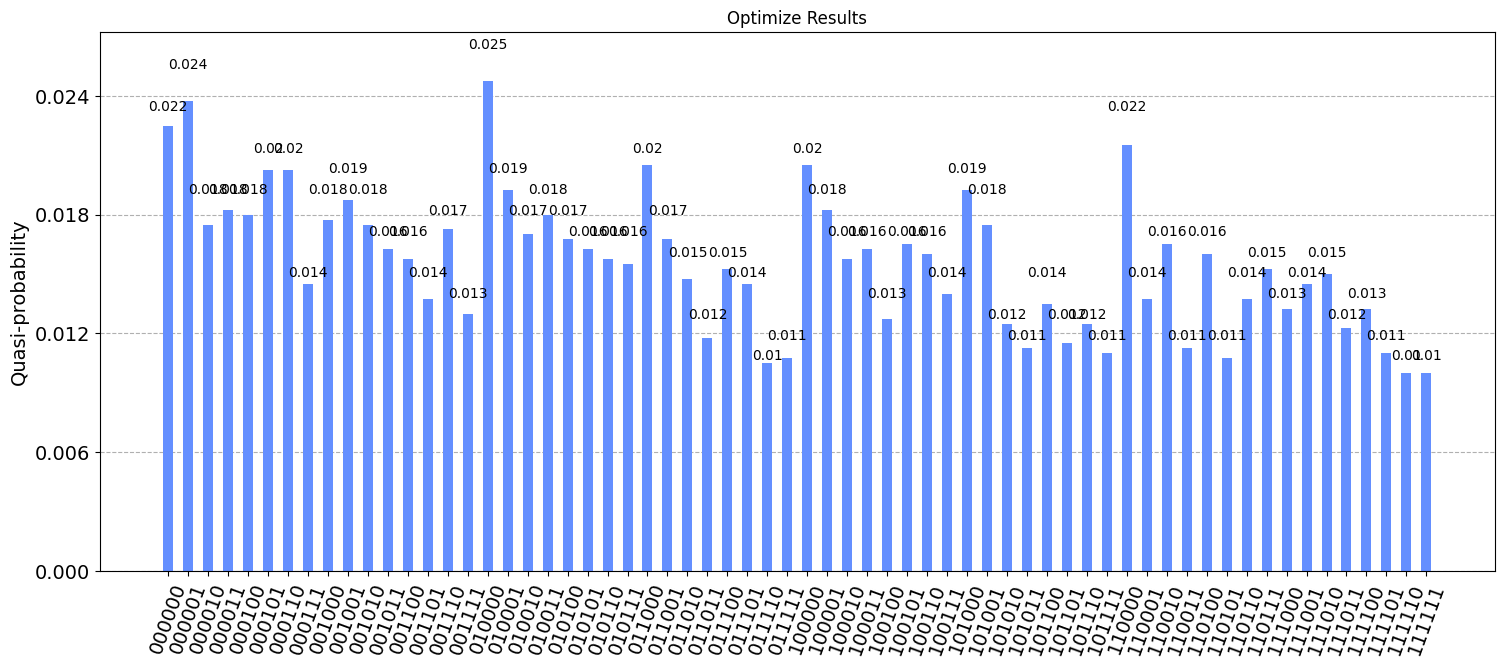

12.55475
cost: 12.55475 



In [18]:
unm = Unified_Noise_Model()

unm.add_depolarizing_channel(depol_noise_prob,['rz', 'ry'],[])

cost = cost_func_test_param(optimal_parameters,num_qubits,num_iterations,unm.noise_model) 
print('cost:',cost,'\n')


* Second, try varying the depolarizing noise level and compare the minimized parameters.
